# Project: Investigating No-Shows in Brasil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

Together, we will examine medical appointment no-shows in Brasil in order to determine what might help predict no-shows in the future. We will aim to answer the following questions:
* What factors are important for us to know in order to predict if a patient will show up?
 * Does the time between the day the appointment was scheduled and the actual appointment impact the percentage of no-shows?
 * Do more patients show up to their appointments if they receive an SMS reminder?
 * Do patients in different age groups have different no-show rates? 
 * Are greater or fewer percentage appointments made by patients with Hypertension and/or Diabetes No-Shows compared to appointments made by patients without these conditions?
 * Are a greater or fewer percentage of appointments made by patients enrolled in the Bolsa Familiar program No-Shows compared to appointments made by patients not enrolled in Bolsa Familia?
 
The dataset used has 110527 records to start, with 14 columns. 
* PatientID
* AppointmentID
* Gender
* ScheduleDay
* AppointmentDay
* Neighborhood
* Scholarship
* Hipertension
* Diabetes
* Alcoholism
* Handcap
* SMS_received
* No-show

**What we know:** We know that ScheduleDay is the day that a patient set up their appointment, Neighborhood is the location of the hospital, and Scholarship is whether or not the patient was enrolled in the welfare progrma Bolsa Familia. We also know that "No" in the no-show column means the patient did show up.

In [1]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ensuring graphs are inline
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

We'll explore the data in order to know what we may need to clean or account for.

In [2]:
#reading in the data and describing it
data_loc = 'noshow_2016.csv'
df = pd.read_csv(data_loc)
df.info() #no null values, and some variable types that we will have to change for our analysis.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [3]:
 df.describe() #age has a -1 value that we'll need to address.

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [4]:
df.query('Age < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [5]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

In [6]:
df.head(1) # we can see that ScheduledDay has so many more unique values because it also includes the time of day.

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


**Notes from brief exploration before cleaning:**

* There is one row where age is less than zero. We will drop this row 99832 or appointment ID 5775010.
* There are 110,527 unique values for the appointment IDs, which means there are no duplicates there to review.
* Handicap looks like it may be categorical, as the max is 4 rather than 1 for yes and 0 for no. However, we are not analyzing this variable and will not explore further at this time.
* There are no fully duplicated rows.
* There are no blank cells in this dataset for any variable.
* For our specific questions, we'll need to change ScheduledDay and AppointmentDay from strings to date-type columns. Additionally, we will want to trim the time of day information off of ScheduledDay to make the two variables comparable.
* We will also have to create an age variable that puts age into categories, and a variable that notes whether someone has Hypertension and/or Diabetes.

In [7]:
#check for fully duplicated rows:
df.duplicated().sum()

0

In [8]:
# Dropping single row where Age < 0
df.drop(df.index[99832], inplace=True)
#df.query('Age < 0') #confirmed drop.

### Data Cleaning

In this section, I will:
* drop the row with negative age values
* change ScheduledDay and AppointmentDay data types to be dates and to both exclude time of day
* create a new column AgeGroups that groups patients into age groups (based on percentiles)
* create a new column Diabetes_Hypertension that notes if a patient has Diabetes and/or Hypertension

**Note:** We will also drop 5 cases where the appointment day is less than the scheduled day, as it is not clear what caused this issue and there are so few cases in this category.

In [9]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date

#print(type(df['ScheduledDay'][0]))
#print(type(df['AppointmentDay'][0])) #both are datetime.date

df['Difference_time'] = df.AppointmentDay-df. ScheduledDay
df['Difference_time'].describe()
#there are some rows where appointment day was before the scheduled day.

#df.query('Difference_time < "0 days"')

count                        110526
mean     10 days 04:24:39.789370826
std      15 days 06:07:14.979140739
min               -6 days +00:00:00
25%                 0 days 00:00:00
50%                 4 days 00:00:00
75%                15 days 00:00:00
max               179 days 00:00:00
Name: Difference_time, dtype: object

**Below, we'll create new columns that will help us analyze no-shows more easily:**
* Days between appointment and when it was scheduled
* Age groups
* Classifier if an appointmetn is for a patient with Diabetes and/or Hypertension

In [10]:
df.drop(df.query('Difference_time < "0 days"').index, inplace = True) 
#df.shape

In [11]:
#creating groups for the Day difference column to make it easier to analyze later.
print(df.Difference_time.describe())
df['Difference_time'] = df['Difference_time'].dt.days.astype('int16')
#type(df['Difference_time'][0])

condition = [
    (df['Difference_time'] == 0),
    (df['Difference_time'] >= 1) & (df['Difference_time'] <= 4),
    (df['Difference_time'] >= 5) & (df['Difference_time'] <= 15), 
    (df['Difference_time'] >= 16) & (df['Difference_time'] <= 179), 
    ]

values = ["same day", "1-4 days", "5-15 days", "16-179 days"]
df['TimeGroups'] = np.select(condition, values)
df.TimeGroups.value_counts()

#utilized this tutorial: https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/

count                        110521
mean     10 days 04:25:27.412889858
std      15 days 06:07:25.262183605
min                 0 days 00:00:00
25%                 0 days 00:00:00
50%                 4 days 00:00:00
75%                15 days 00:00:00
max               179 days 00:00:00
Name: Difference_time, dtype: object


same day       38562
16-179 days    26246
5-15 days      25748
1-4 days       19965
Name: TimeGroups, dtype: int64

In [12]:
# make grouped age variable.

print(df.Age.describe()) 
#bin edges for age groups will be based on percentiles, so 0-18, 19-37, 38-55, and 56-115.

bin_edges = [0, 18, 37, 55, 115]
bin_names = ["Ages 0-18", "Ages 19-37", "Ages 38-55", "Ages 56-115"]
df['AgeGroups'] = pd.cut(df['Age'], bin_edges, labels=bin_names)

df.AgeGroups.value_counts()

count    110521.000000
mean         37.089386
std          23.109885
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64


Ages 56-115    27503
Ages 19-37     27248
Ages 38-55     26905
Ages 0-18      25326
Name: AgeGroups, dtype: int64

In [13]:
# make binary column for if someone has Diabetes and/or Hypertension
condition_2 = [
    (df['Diabetes'] == 1) | (df['Hipertension'] == 1),
    (df['Diabetes'] == 0) & (df['Hipertension'] == 0)
    ]

values_2 = [1, 0]
df['Diabetes_Hypertension'] = np.select(condition_2, values_2)
#df.head()

#utilized this tutorial: https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/

<a id='eda'></a>
## Exploratory Data Analysis

First, Let's look at our No-Show column on its own to get a sense of how many no-shows there are.
We can see from the counts that there are over 20,000 No-Shows, but that it's far more common to keep one's appointment.

Text(0, 0.5, 'Count')

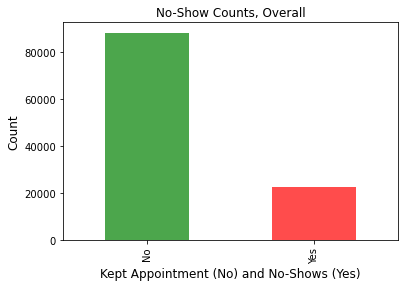

In [14]:
colors = ['green','red'] #cleaning up
show_counts = df.groupby('No-show')['AppointmentID'].count()
show_counts.plot(kind='bar', title='No-Show Counts, Overall', color=colors, alpha=.7)
plt.xlabel('Kept Appointment (No) and No-Shows (Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

### <font color='orange'> Research Question 1:  Does the time between the day the appointment was scheduled and the actual appointment impact the percentage of no-shows? </font>

First, let's look at appointment date and schedule date independently from No-Shows. Below, we can see that over 50% of appointments were scheduled only 4 days prior to the appointment date, with 25% of appointments occuring on the same day.

count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: Difference_time, dtype: float64


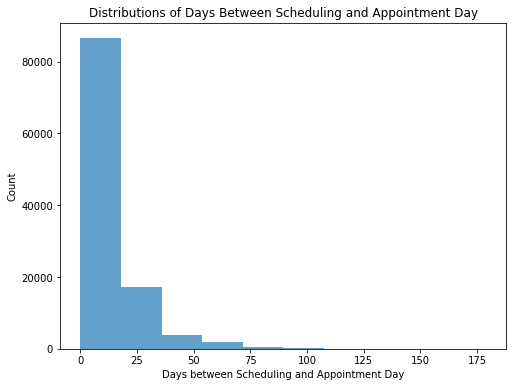

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist (df['Difference_time'], alpha = 0.7, label = 'Time Difference')
ax.set_title('Distributions of Days Between Scheduling and Appointment Day')
ax.set_xlabel('Days between Scheduling and Appointment Day')
ax.set_ylabel('Count')

print(df['Difference_time'].describe())
plt.show()

Now Let's look at how the percent of no-shows varies by the difference between the time the appointment was scheduled and the actual appointment day. We'll have to first create groups for the date difference, and I will use percentiles.

In [16]:
#Let's explore our calculated variable that measures the number of days between the appointment day and the scheduled day.
# get counts of No-Shows (yes) or Shows (no) for each Time Difference Group

time_counts = df.groupby(['TimeGroups','No-show']).count()['AppointmentID']
time_totals = df.groupby('TimeGroups').count()['AppointmentID']
#print(time_counts)
#print(time_totals)

sameday_proportions = (time_counts['same day'] / time_totals['same day']).sort_values()
day1to4_proportions = (time_counts['1-4 days'] / time_totals['1-4 days']).sort_values()
day5to15_proportions = (time_counts['5-15 days'] / time_totals['5-15 days']).sort_values()
day16to179_proportions = (time_counts['16-179 days'] / time_totals['16-179 days']).sort_values()

sameday_proportions = sameday_proportions.drop(["No"]);
day1to4_proportions = day1to4_proportions.drop(["No"]);
day5to15_proportions = day5to15_proportions.drop(["No"]);
day16to179_proportions = day16to179_proportions.drop(["No"]);

print("Same Day % No Shows", sameday_proportions)
print("1-4 Days % No Shows", day1to4_proportions)
print("5-15 Days % No Shows", day5to15_proportions)
print("16-179 Days % No Shows", day16to179_proportions)

time_series = pd.Series([0.046471,0.229902,0.285381,0.327059], index=['Same Day', '1-4 Days', '5-15 Days', '16-179 Days'])
#Note to reviewer: this seems really cumbersome. 
#Any suggestions on how to get % no-shows graphed for these categories would be super helpful.

Same Day % No Shows No-show
Yes    0.046471
Name: AppointmentID, dtype: float64
1-4 Days % No Shows No-show
Yes    0.229902
Name: AppointmentID, dtype: float64
5-15 Days % No Shows No-show
Yes    0.285381
Name: AppointmentID, dtype: float64
16-179 Days % No Shows No-show
Yes    0.327059
Name: AppointmentID, dtype: float64


Same Day        4.6471
1-4 Days       22.9902
5-15 Days      28.5381
16-179 Days    32.7059
dtype: float64


Text(0.5, 0, 'Days between Scheduling Day and Appointment Day')

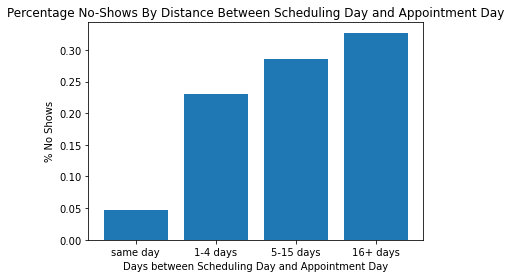

In [17]:
print(time_series*100,)
locations = [1,2,3,4]
heights = time_series
labels = ['same day', '1-4 days', '5-15 days', '16+ days']  # xtick labels

time_graph = plt.bar(locations, heights, tick_label=labels)

plt.title("Percentage No-Shows By Distance Between Scheduling Day and Appointment Day")
plt.ylabel("% No Shows")
plt.xlabel("Days between Scheduling Day and Appointment Day")

**Research Question 1, Notes:**

We can see that the percentage of No-Shows appears to increase as the distance between the date the appointment was scheduled and the date of the actual appointment increases, with 5% of No-Shows for same-day appointments, 23% No-Shows for appointments 1-4 days after scheduling, 29% No-Shows for appointments scheduled 5-15 days prior, and 33% No-Shows for appointments scheduled 16 days or more prior.

This finding, however, does not mean that earlier appointments in and of themselves may reduce No-Shows, as certain kinds of patient needs may be more urgent, and therefore scheduled for more rapid intake, than others. Same-day appointments also may imply that the patient was already at the hospital for a first appointment.

### <font color='orange'> Research Question 2: Do more patients show up to their appointments if they receive an SMS reminder? </font>


First, let's look at SMS reminders independently of No-Shows. It looks like sending an SMS reminder is a lot less common than not sending one.

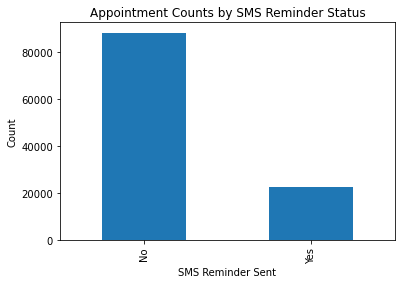

In [18]:
df['No-show'].value_counts().plot(kind='bar', title = "Appointment Counts by SMS Reminder Status", xlabel = "SMS Reminder Sent", ylabel = "Count");

Now Let's look at percentages of No-Shows for patients by whether or not they received an SMS.

In [19]:
SMS_counts = df.groupby(['SMS_received','No-show']).count()['AppointmentID']
print(SMS_counts)
SMS_totals = df.groupby('SMS_received').count()['AppointmentID']
print(SMS_totals)

SMS_proportions = (SMS_counts[1] / SMS_totals[1]).sort_values()
NoSMS_proportions = (SMS_counts[0] / SMS_totals[0]).sort_values()

SMS_proportions = SMS_proportions.drop(["No"]);
NoSMS_proportions = NoSMS_proportions.drop(["No"]);

print("Received SMS: % No-Shows",SMS_proportions)
print("No SMS: % No-Shows", NoSMS_proportions)

SMS_received  No-show
0             No         62509
              Yes        12530
1             No         25698
              Yes         9784
Name: AppointmentID, dtype: int64
SMS_received
0    75039
1    35482
Name: AppointmentID, dtype: int64
Received SMS: % No-Shows No-show
Yes    0.275745
Name: AppointmentID, dtype: float64
No SMS: % No-Shows No-show
Yes    0.16698
Name: AppointmentID, dtype: float64


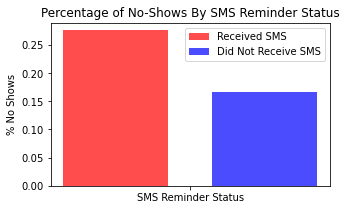

In [20]:
#Note to reviewer: I use a different approach for graphing here, to avoid having to put in manual values, 
#but it still feels very cumbersome and prone to error. Advice or Resources appreciated.
#maybe some kind of aggregation + reorganization + % calculations?

locations = np.arange(len(SMS_proportions))  # the x locations for the groups
width = 0.35 # the width of the bars
plt.figure(figsize=(5,3))

SMS_bars = plt.bar(locations, SMS_proportions, width, color='r', alpha=.7, label="Received SMS")
NoSMS_bars = plt.bar(locations + 0.5, NoSMS_proportions, width, color='b', alpha=.7, label="Did Not Receive SMS")

# title and labels
plt.ylabel('% No Shows')
plt.title('Percentage of No-Shows By SMS Reminder Status');


# labels
locations = locations + 0.5 / 2  # xtick locations
labels = ['SMS Reminder Status']  # xtick labels
plt.xticks(locations, labels)

# legend
plt.legend();

**Research Question 2, Notes:**

A greater percentage of patients who received SMS reminders did not show up to their appointments (28%) compared to those who did not receive an SMS reminder (17%).

This again does not imply that not sending an SMS would yield lower No-Show rates, and could have something to do with who has signed up to receive SMS reminders, which types of appointments receive SMS reminders. or something else.


###  <font color='orange'> Research Question 3: Do patients in different age groups have different no-show rates? </font>

First, let's look at age indpendently to get a sense of the distribution. It looks like the data skews right, and that the largest bin is for appointments made for patients 10 years old or younger.

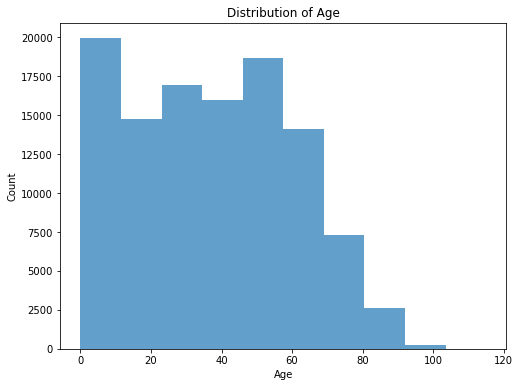

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist (df['Age'], alpha = 0.7, label = 'Age')
ax.set_title('Distribution of Age')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()

Let's look at whether different age groups have different No-Show rates, similar to how we looked at time differences and SMS reminders.

In [22]:
Age_counts = df.groupby(['AgeGroups','No-show']).count()['AppointmentID']
Age_totals = df.groupby(['AgeGroups']).count()['AppointmentID']
age_proportions = (Age_counts / Age_totals).sort_values()
print(age_proportions)

age_series = [0.225350, 0.235320, 0.195280, 0.156419] #taking age proportions for No-Shows and sorting by age group

AgeGroups    No-show
Ages 56-115  Yes        0.156419
Ages 38-55   Yes        0.195280
Ages 0-18    Yes        0.225342
Ages 19-37   Yes        0.235320
             No         0.764680
Ages 0-18    No         0.774658
Ages 38-55   No         0.804720
Ages 56-115  No         0.843581
Name: AppointmentID, dtype: float64


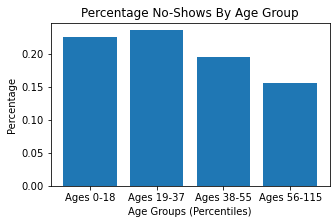

In [23]:
locations_age = [1,2,3,4]
heights_age = age_series
labels_age = ['Ages 0-18', 'Ages 19-37', 'Ages 38-55', 'Ages 56-115']

plt.figure(figsize=(5,3))
plt.title("Percentage No-Shows By Age Group")
plt.ylabel("Percentage")
plt.xlabel("Age Groups (Percentiles)")

ages_graph = plt.bar(locations_age, heights_age, tick_label=labels_age)

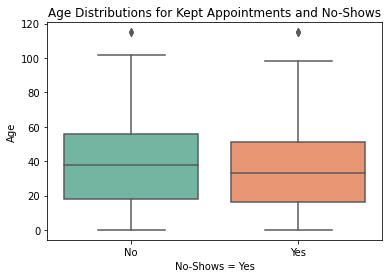

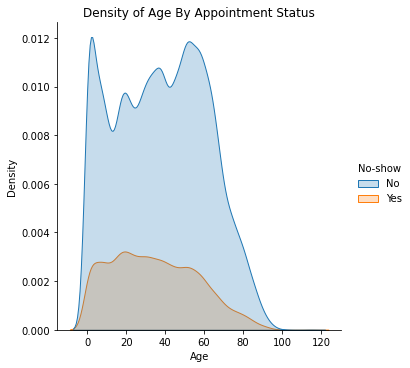

In [24]:
#We can also look at age among no-shows without grouping through box plots. 

df_noshows = pd.DataFrame(data=df, columns=['Age','No-show'])

graph = sns.boxplot(x="No-show", y="Age", data=df_noshows, palette="Set2").set(title='Age Distributions for Kept Appointments and No-Shows',xlabel='No-Shows = Yes')

# utilized this tutorial for boxplots in seaborn: https://seaborn.pydata.org/generated/seaborn.boxplot.html
# used this for plot title adjustments: sns.boxplot('Day', 'Count', data=gg).set(title='lalala', xlabel='its x_label', ylabel='its y_label')

sns.displot(df, x="Age", hue="No-show", kind="kde", fill=True).set(title='Density of Age By Appointment Status');

# tutorial for density plot: https://seaborn.pydata.org/tutorial/distributions.html

**Research Question 3, Notes:**

There is evidence that No-Show rates are higher among patients ages 0-18 (23%) and 19-37 (24%) than among patients who are older than 38. Additionally, No-Show rates are lowest among patients over the age of 56 (16%).

The boxplot shows that the mean age of patients who kept their appointments is higher than the mean age of patients for no-show appointments; the density plot shows a similar picture where a greater proportion of No-shows were for appointments made by younger patients.

This is not to say that age causes more no-shows, but that there may be some relationship between age and no-shows. For example, schedules may change or be less flexible for younger patients, or there may be more "important" appointments for older patients that are more costly (in terms of health) to miss. 

### <font color='orange'>Research Question 4: Do greater or fewer percentage patients with Hypertension and/or Diabetes show up compared to patients without these conditions? </font>

Let's look at whether a greater proportion of appointments made by patients with Diabetes and/or Hypertension were kept compared to patients without either condition.

In [25]:
diabetes_hypertension_counts = df.groupby(['Diabetes_Hypertension', 'No-show']).count()['AppointmentID']
diabetes_hypertension_totals = df.groupby('Diabetes_Hypertension').count()['AppointmentID']
diabetes_hypertension_proportions = (diabetes_hypertension_counts / diabetes_hypertension_totals)
diabetes_hypertension_proportions

Diabetes_Hypertension  No-show
0                      No         0.790828
                       Yes        0.209172
1                      No         0.825393
                       Yes        0.174607
Name: AppointmentID, dtype: float64

**Research Question 4, Notes:**

No-Show rates were slightly lower among appointments made by patients with Diabetes and/or Hypertension (17%) compared to patients with neither of these conditions (21%). This result will not be graphically displayed as it is one of the smaller findings.

### <font color='orange'> Research Question 5: Are a greater or fewer percentage of appointments made by patients enrolled in the Bolsa Familiar program No-Shows compared to appointments made by patients not enrolled in Bolsa Familia? </font>

First, let's look at Bolsa Familia status independently of No-Shows. From the graph below, it's clear that the vast majority of appointments are made by patients who are not enrolled in the Bolsa Familia welfare program.

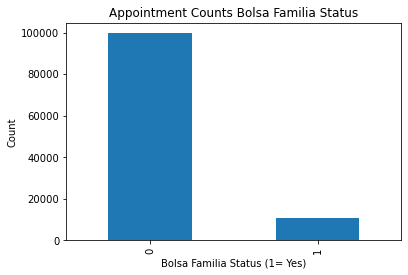

In [26]:
df['Scholarship'].value_counts().plot(kind='bar', title = "Appointment Counts Bolsa Familia Status", xlabel = "Bolsa Familia Status (1= Yes)", ylabel = "Count");

Now, let's look at our last research question related to Bolsa Familia.

In [27]:
BolsaFamilia_counts = df.groupby(['Scholarship', 'No-show']).count()['AppointmentID']
BolsaFamilia_totals = df.groupby('Scholarship').count()['AppointmentID']
BolsaFamilia_proportions = (BolsaFamilia_counts / BolsaFamilia_totals)
BolsaFamilia_proportions

Scholarship  No-show
0            No         0.801967
             Yes        0.198033
1            No         0.762637
             Yes        0.237363
Name: AppointmentID, dtype: float64

**Research Question 5, Notes:**

No-Show rates were slightly higher for appointments made by patients in the Bolsa Familia welfare program (24%) than those who were not enrolled in this program (20%). This result will not be graphically displayed as it is one of the smaller findings.

<a id='conclusions'></a>
## Conclusions

In this workbook, I have explored the relationship between No-Shows and 5 features:
* Scheduling Delay Groups (time between Schedule Day and Appointment Day)
* SMS Reminder Status
* Age Groups
* Diabetes / Hypertension Status
* Bolsa Familia Scholarship Status

The greatest differences in No-Show rates were across **Scheduling Delay Groups, SMS Reminder Status, and Age Groups.**
* Specifically, only 5% of same-day appointments and 23% of appointments made 1-4 days prior were No-Shows, compared to patients hwho made appointments 5 or more days in advance (29% if 5-15 days in advance, and 33% if more than 16 days in advance). This could be due to the urgency of the appointments with shorter wait times, or ease of scheduling and remembering events in the near future. 
* Interestingly, appointments where SMS Reminders were not sent out had lower No-Show rates; this may be due to the type of patient who opts in to or can receive SMS Reminders. 
* Finally, appointments made by younger patients had higher rates of No-Shows; this may be due to the urgency of the appointment in terms of one's health or that scheduling presents more challenges for younger patients. 

### Limitations

I explored the relationship between two features at a time and only in a descriptive manner. This means that I am only describing the data from a few angles and am not implying causality or statistically significant differences. The next steps would be to look at relationships across multiple features (perhaps using a logistic regression) and to test for statistical relevance of any findings. For example, we could explore how age combined with SMS reminders impacts the rate of No-Shows, and then test differences across groups to check for significance.

Additionally, I looked at very few features just as a sample. There may be other features in this dataset that would be more informative than the ones I chose, and therefore my analysis represents only a sliver of the whole picture. 

Finally, I did remove a few rows of data due to impossible values (like negative age) or problematic values (appointment event before it was scheduled), and have reason to believe that the data I am seeing is only for appointments that contained all data (as there are no missing values for any rows). Additionally, this data represents a small portion of appointments for the year under review, and any trends or patterns related to no-shows may change throughout the year (seasonality) or across years.